# <center>Essential Site Scanning Analysis Tutorial</center>

This tutorial demonstrates how to use ESSA for determining the essential sites that would significantly alter the global/functional dynamics of a protein upon ligand binding. ESSA emulates ligand binding by increasing the node density around each scanned residue. This is achieved by adding extra nodes at the positions of the specific residue’s heavy atoms (other than the C-alpha atoms that define the reference network in GNM or ANM).

Let's import all the required packages!

In [1]:
from prody import *
from numpy import *
from matplotlib.pyplot import *
import pandas as pd   # it is only required,
                      # if you do any data manupilation, later.

%matplotlib inline
import matplotlib.pyplot as plt
confProDy(auto_show=False)
confProDy(auto_secondary=True)

@> ProDy is configured: auto_show=False
@> ProDy is configured: auto_secondary=True


# Generation of ESSA profile

First, we need to parse the structure on which we want to perform ESSA.

In this tutorial, we will fetch the TEM-1 beta-lactamase (1pzo) from the PDB.

In [2]:
pdb = parsePDB('1pzo', compressed=False)

@> PDB file is found in working directory (1pzo.pdb).
@> 2250 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 187 residues.


ESSA is implemented as a ProDy class, so we can instantiate an `ESSA` object.

In [3]:
essa = ESSA()

Before starting residue scanning, we first need to set the system. Even though the *ligand(s) are not included* in the scanning, they can be specified for further analysis. For this purpose, you can simply give the chain ids and residue numbers as a string shown in the following. The protein residues interacting with each ligand can be determined within a specific cutoff distance (default `dist=4.5`). ESSA will use the title of the atomic object in the names of the output files.

ESSA, by default, generates a `ModeEnsemble` containing the modes resulting from the perturbation of each residue. However, if the user does not have enough memory resources for conducting computation on a large structure, then `lowmem=True` should be chosen, thus only storing eigenvalues/eigenvectors for each perturbed model.

In the structure 1pzo, there are two identical allosteric inhibitors (residues 300 and 301 of chain A). ESSA can be informed about them when setting the system as follows:

In [4]:
#essa.setSystem(pdb)
essa.setSystem(pdb, lig='A 300 A 301')

Scanning can be done using `scanResidue()`. Here you can specify the number of softest modes, the type of ENM (GNM or ANM), and the cutoff, which by default are `n_modes=10`, `enm='gnm'`, `cutoff=None`, respectively. If cutoff is not specified, its value is adopted from the default value of the specified ENM. During the scanning, the progress will also be displayed.

In [5]:
essa.scanResidues()

@> Kirchhoff was built in 0.05s.
@> 10 modes were calculated in 0.02s.
@> Matching 10 modes across 264 modesets... [ 99%] 1s

The generated ESSA profile can be shown by `showESSAProfile()`. On this profile, the residues interacting with the previously specified ligand(s) are automatically highlighted. The blue dashed baseline shows the q-th quantile of the profile, which is by default `q=0.75`, representing the top quartile.

Other residues of interest can also be indicated with their single-letter code and residue number on this plot if specified by a ProDy selection string provided as a parameter.

We can dynamically customize the properties of the plot using the matplotlib context manager as shown below.

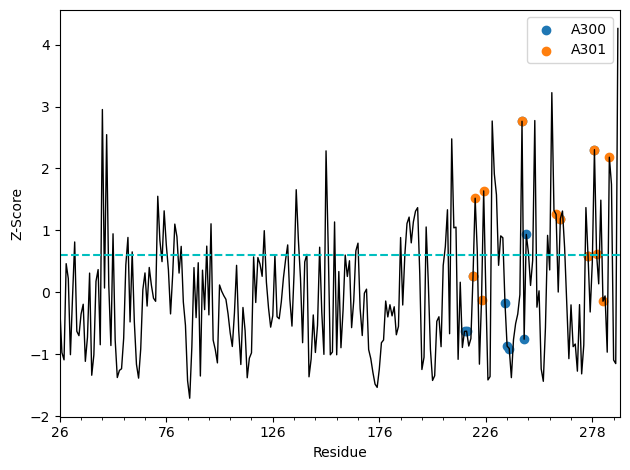

In [6]:
with style.context({'figure.dpi': 100}):
    essa.showESSAProfile()

Other residues of interest can also be indicated with their single-letter code and residue number on this plot if specified by a ProDy selection string provided as a parameter. If you would like to save this figure, you can use the function plt.savefig() shown below.

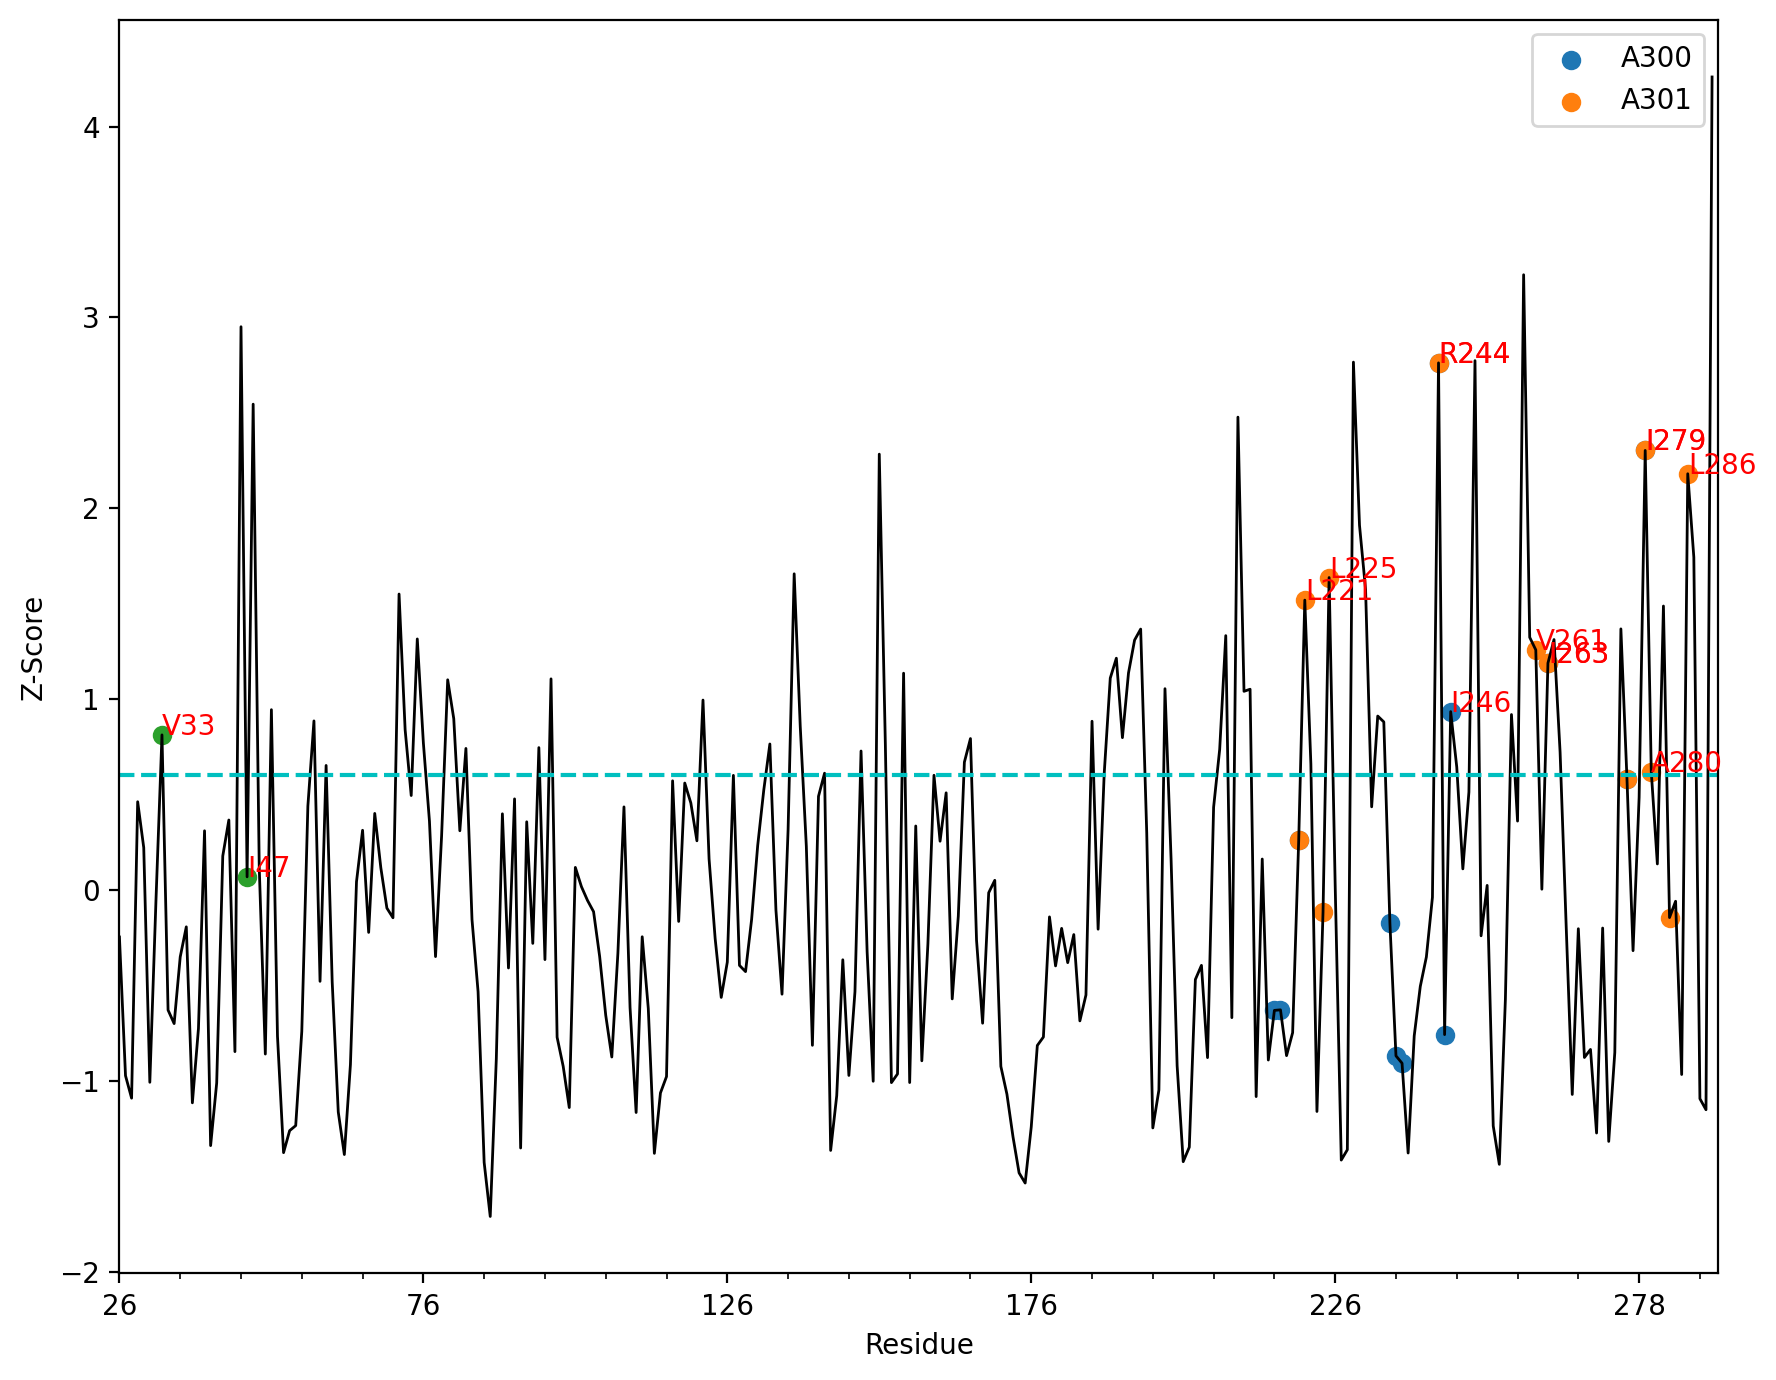

In [20]:
with style.context({'figure.figsize': (9, 7), 'figure.dpi': 200}):
    essa.showESSAProfile(q=.75, rescode=True, sel='chain A and resnum 33 47')
plt.savefig("essa.pdf")

ESSA z-scores can be obtained as a NumPy array using `getESSAZscores()`, and saved with `saveESSAZscores()`. Let’s have the z-scores of the first ten residues:

In [21]:
essa.getESSAZscores()[:10]

array([-0.24676638, -0.97356457, -1.09135811,  0.46199512,  0.22145561,
       -1.00814207, -0.06428016,  0.812289  , -0.62965247, -0.70051851])

If you would like to save the z-scores as a .txt file, you can simply use the following commands.

In [23]:
essa_zscores = essa.getESSAZscores()
writeArray('essa_zscores_1pzo.txt', essa_zscores, format='%.5f')

'essa_zscores_1pzo.txt'

If you would like to save the z-scores as an numpy array (.npy) file, the following command can be used:

In [24]:
essa.saveESSAZscores()

In order to visualize the essential residues, a PDB file can be generated, in which the z-scores are written in the B-factor column. Later, this file can be opened in a molecular graphics program such as PyMOL or VMD, where the structure can be colored according to the B-factors.The pdb file saved will be the orignal pdb name + '_zs.pdb'. In this example, the saved pdb is '1pzo_zs.pdb'

In [25]:
essa.writeESSAZscoresToPDB()

In [26]:
# !vmd

# Prediction of allosteric pockets

Allosteric pocket prediction requires Fpocket 3.0 and Pandas installed in your system. The first step is the pocket hunting, which is automatically carried out in the background, by calling `scanPockets()`. This method parses the pocket features provided by Fpocket, and all identified pockets are stored in a folder ending with **_out** in the current working directory. Additionally, maximum/median ESSA scores are assigned to each pocket based on the ESSA scores of the residues forming it.

In [27]:
essa.scanPockets()

***** POCKET HUNTING BEGINS ***** 


@> Retrieving pocket7_atm.pdb... [ 85%] 1s

***** POCKET HUNTING ENDS ***** 


Pocket features that are stored in a Pandas DataFrame can be obtained by getPocketFeatures(), and saved as a Python pickle file by `savePocketZscores()`.

Key features of the pockets to be used in the prediction, namely ESSA and local hydrophobic density (LHD) z-scores, can be listed by `getPocketZscores()`.

In [28]:
essa.getPocketZscores()

Z-score,ESSA_max,ESSA_med,LHD
Pocket #,,,
1,1.051557,-0.748037,-0.674785
2,0.571688,-0.293197,-0.314441
3,1.137016,-0.332065,-0.068207
4,2.283472,0.283524,-0.134270
5,1.137016,0.579200,-0.674785
6,2.773325,0.392536,2.386841
7,0.177499,-1.011726,-0.520354


The prediction protocol ranks the pockets with respect to their ESSA and LHD z-scores. Concurrently, the pockets with negative LHD z-scores are filtered out as allosteric sites are known to have relatively higher LHD.

Ranking of the pockets can be performed and obtained by `rankPockets()` and `getPocketRanks()`, respectively.

In [31]:
essa.rankPockets()

In [32]:
essa.getPocketRanks()

,Pocket # (ESSA_max & LHD),Pocket # (ESSA_med & LHD)
Rank,,
1,6,6


**Pocket 6** with the top ESSA_max score has been identified as the only allosteric pocket in this structure. Interestingly, other pockets have been filtered out due to their negative LHD z-scores. Pocket 6 is a large pocket that includes CBT allosteric ligands at A300 and A301.

In order to visualize the pockets, the `pqr`, `.sh`, or `.tcl` file, an output of Fpocket needs to be opened by PyMOL or VMD together with the original pdb file.

In [ ]:
# !vmd

Pocket z-scores and ranks can be saved by `savePocketZscores()` and `writePocketRanksToCSV()`, respectively.

In [33]:
essa.savePocketZscores()

In [34]:
essa.writePocketRanksToCSV()